In [1]:
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, sin_beta, mono_beta, sin_beta_dfe, first_below_threshold
import utils.plotting as plotting
from utils.eval import eval_predictions, format_latex_table
import numpy as np

2026-02-17 00:29:34.036427: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-17 00:29:34.095087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-17 00:29:36.949535: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
E0000 00:00:1771298980.041241  401980 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will n

Set the default float type to float64


In [ ]:
t_0, t_f, N = 0, 50, 100
nop_data = 100
S0, I0, R0 = 99, 1, 0
noise_std = N * 0.00
gamma = 0.25
test_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(sin_beta_dfe,
    gamma=gamma,
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(test_t)
sir_data = rkdata.generate(test_t, noise_std)

In [3]:
sir_data[:,1]

array([ 1.        ,  1.25681565,  1.59395137,  2.03723054,  2.61852319,
        3.37493307,  4.34423271,  5.57564284,  7.10187603,  8.92986218,
       11.0415373 , 13.3946654 , 15.86965827, 18.33485801, 20.66704914,
       22.75145854, 24.48175552, 25.76681059, 26.60310181, 27.04085246,
       27.13043084, 26.92146751, 26.46285537, 25.80274959, 24.98856766,
       24.06698937, 23.08274446, 22.05776602, 21.00568055, 19.94026346,
       18.87290883, 17.81262943, 16.76605667, 15.73744064, 14.72865008,
       13.73917242, 12.77380835, 11.84243424, 10.94833844, 10.0942765 ,
        9.28248294,  8.51467115,  7.79203348,  7.11524117,  6.48444439,
        5.89927224,  5.35883128,  4.86167927,  4.40602841,  3.98995012,
        3.61138456,  3.26814064,  2.957896  ,  2.67819701,  2.42645879,
        2.19996521,  1.99586885,  1.81147215,  1.64494236,  1.49460744,
        1.35888488,  1.23628406,  1.12540637,  1.02494512,  0.93368558,
        0.85050497,  0.77437248,  0.70436272,  0.64000794,  0.58

In [4]:
dfe_value, dfe_point = first_below_threshold(sir_data[:,1], threshold=1)
dfe_value, dfe_point

(np.float64(0.9336855787808025), np.int64(64))

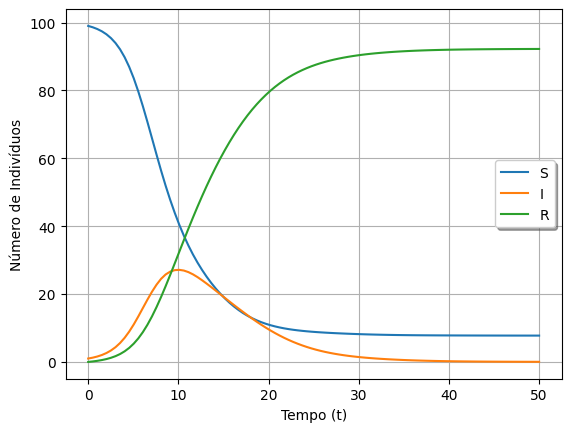

In [5]:
plotting.plot_rk_curves(test_t, sir_real)

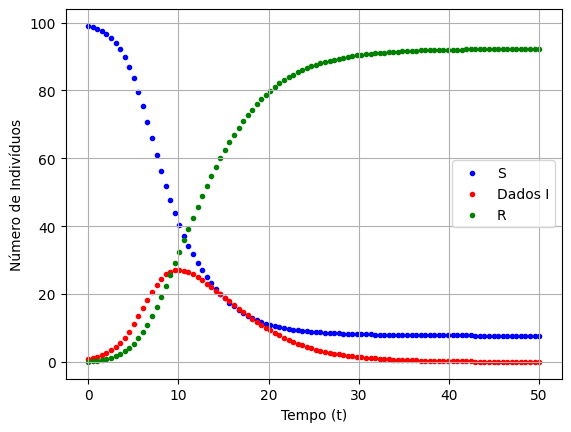

In [6]:
plotting.plot_rk_data(test_t, sir_data, 
    # vlines=[(dfe_point, "DFE", "red")], 
    figname="rk-data-dfe")

In [ ]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], test_t,
    N=N,
    gamma=gamma,
    beta_estimation_window=10,
    hidden_layer_size=40,
    n_hidden_layers=2,
    w_physics=10,
    scaling="norm",
    activation="tanh",
    adam_iterations=500000,
    # parallel_pinns=True,
    estimate_beta=True,
    # early_stopping=True,
    # adaptative_wdata=True,
    beta_hard_constraints=False,
    fine_tunning_using_lbfgs=False)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.002587 s



(np.float64(0.99), np.float64(0.01), np.float64(0.34614272082467923))

In [8]:
model.train()

(<deepxde.model.LossHistory at 0x7f311d1f6bd0>,
 <deepxde.model.TrainState at 0x7f311f3ef210>)

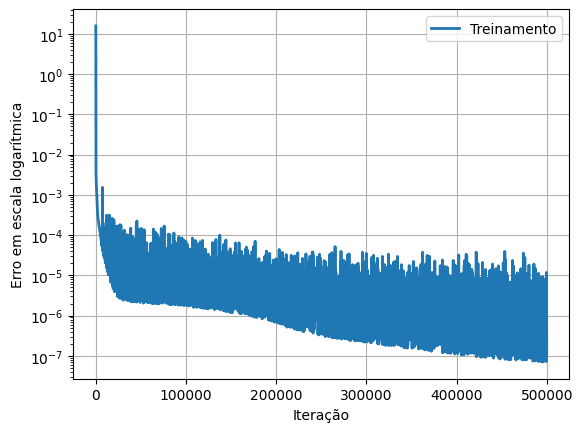

In [9]:
plotting.plot_losshistory(model.losshistory, "loss-dfe")

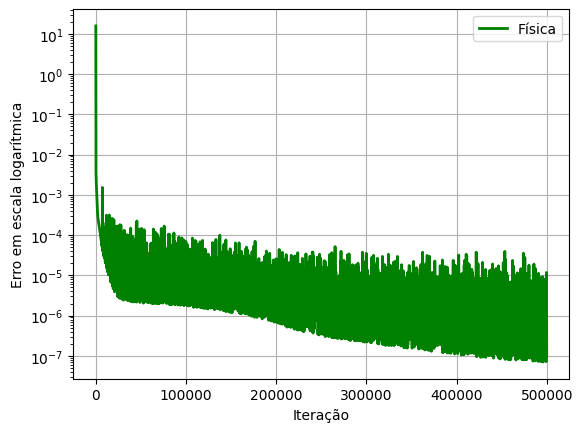

In [10]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-physics-dfe")

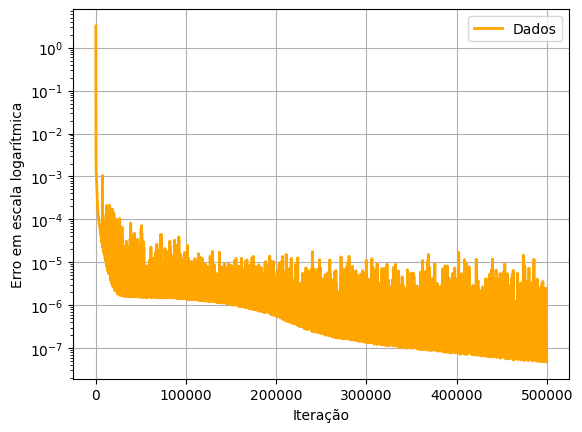

In [11]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-dfe")

In [12]:
predictions = model.predict(test_t)

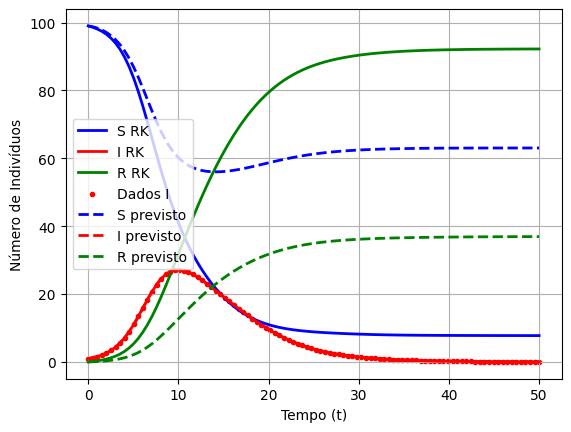

In [13]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N, 
    # vlines=[(dfe_point, "DFE", "purple")],
    figname="results-dfe")

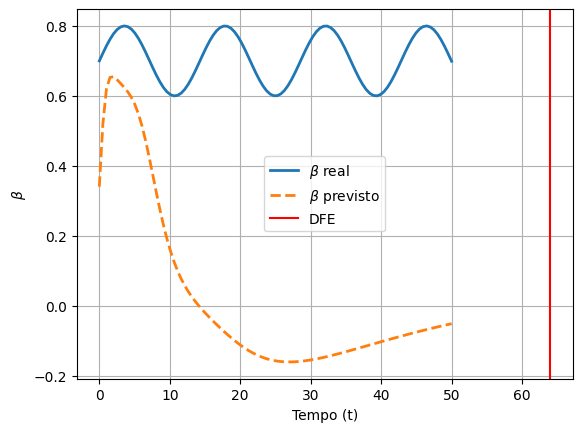

In [14]:
real_beta = sin_beta_dfe(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t,
    vlines=[(dfe_point, "DFE", "red")],
    figname="predicted-beta-dfe" 
)

In [15]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [16]:
real_values = stack_real_values(sir_real, real_beta)
metrics = eval_predictions(real_values, predictions)

In [17]:
metrics

,compartiment,RMSE,L2,L-infinity
0,S,45.053693,1.174084,55.282403
1,I,0.022512,0.001954,0.085965
2,beta,0.724426,1.016904,0.946308


In [18]:
format_latex_table(metrics)

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 45.053693 & 1.174084 & 55.282403 \\\\\n1 & I & 0.022512 & 0.001954 & 0.085965 \\\\\n2 & beta & 0.724426 & 1.016904 & 0.946308 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
model.formated_total_training_time

'00:12:21'